<a href="https://colab.research.google.com/github/arminsoltan/mohaymen/blob/main/Phase02/NN_HeartData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [22]:
import warnings
warnings.simplefilter("ignore")

In [23]:
f = open("SAheart.info.txt", encoding='utf-8')
print(f.read())
f.close()

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

To read into R:
read.table("http://www-stat.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.data",
	sep=",",head=T,row.names=1)



In [24]:
data = pd.read_csv("SAheart.data.csv")
data = data.drop("row.names", axis=1)
data = pd.get_dummies(data)
data = data[['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Absent', 'famhist_Present', 'chd']]
data.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist_Absent,famhist_Present,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.584416,0.415584,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.493357,0.493357,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000,0.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000,0.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,1.000000,0.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000,1.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000,1.000000,1.000000


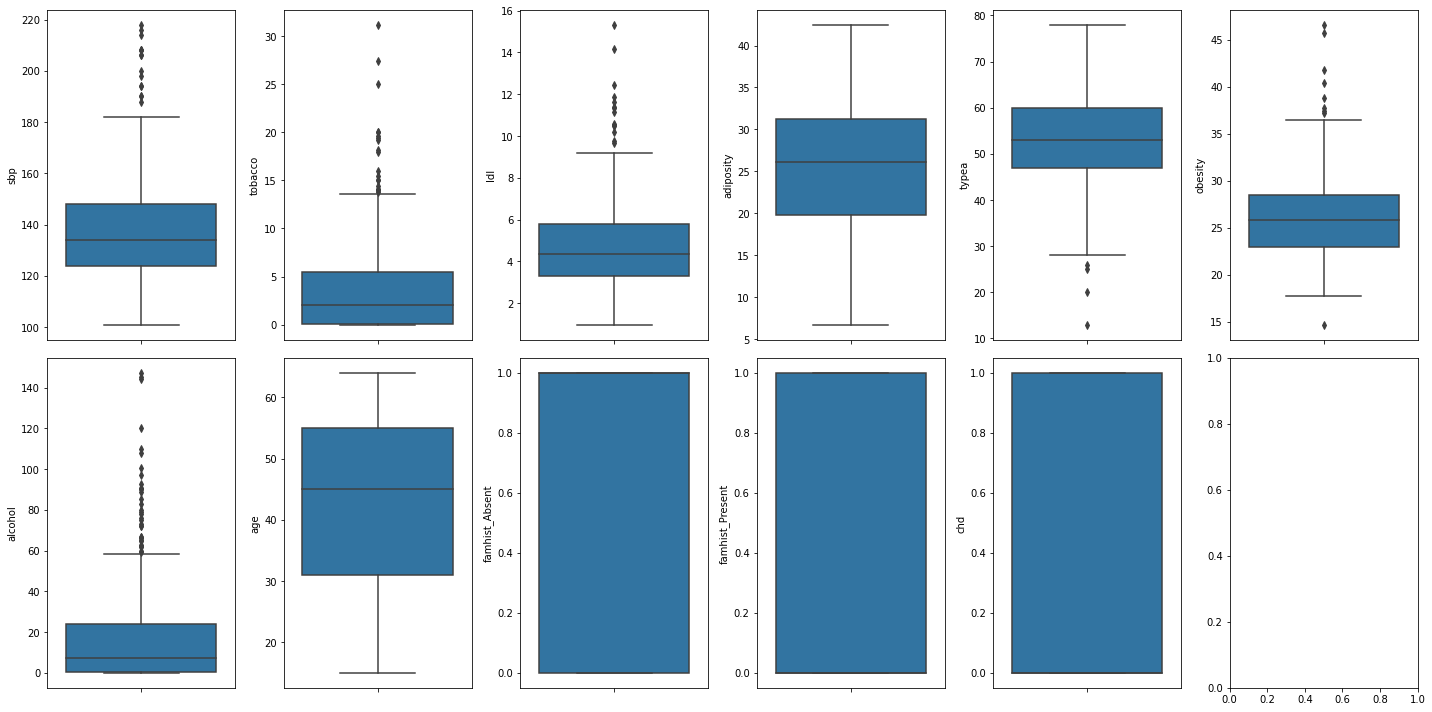

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(20, 10))
axs = axs.flatten()
index = 0
for k, v in data.items():
  sns.boxplot(y=k, data=data, ax=axs[index])
  index += 1
plt.tight_layout()

In [26]:
for k, v in data.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100 / np.shape(data)[0]
  print(f"outlier for {k} is equal {perc:.2f}")

outlier for sbp is equal 3.25
outlier for tobacco is equal 4.11
outlier for ldl is equal 3.03
outlier for adiposity is equal 0.00
outlier for typea is equal 0.87
outlier for obesity is equal 1.95
outlier for alcohol is equal 7.14
outlier for age is equal 0.00
outlier for famhist_Absent is equal 0.00
outlier for famhist_Present is equal 0.00
outlier for chd is equal 0.00


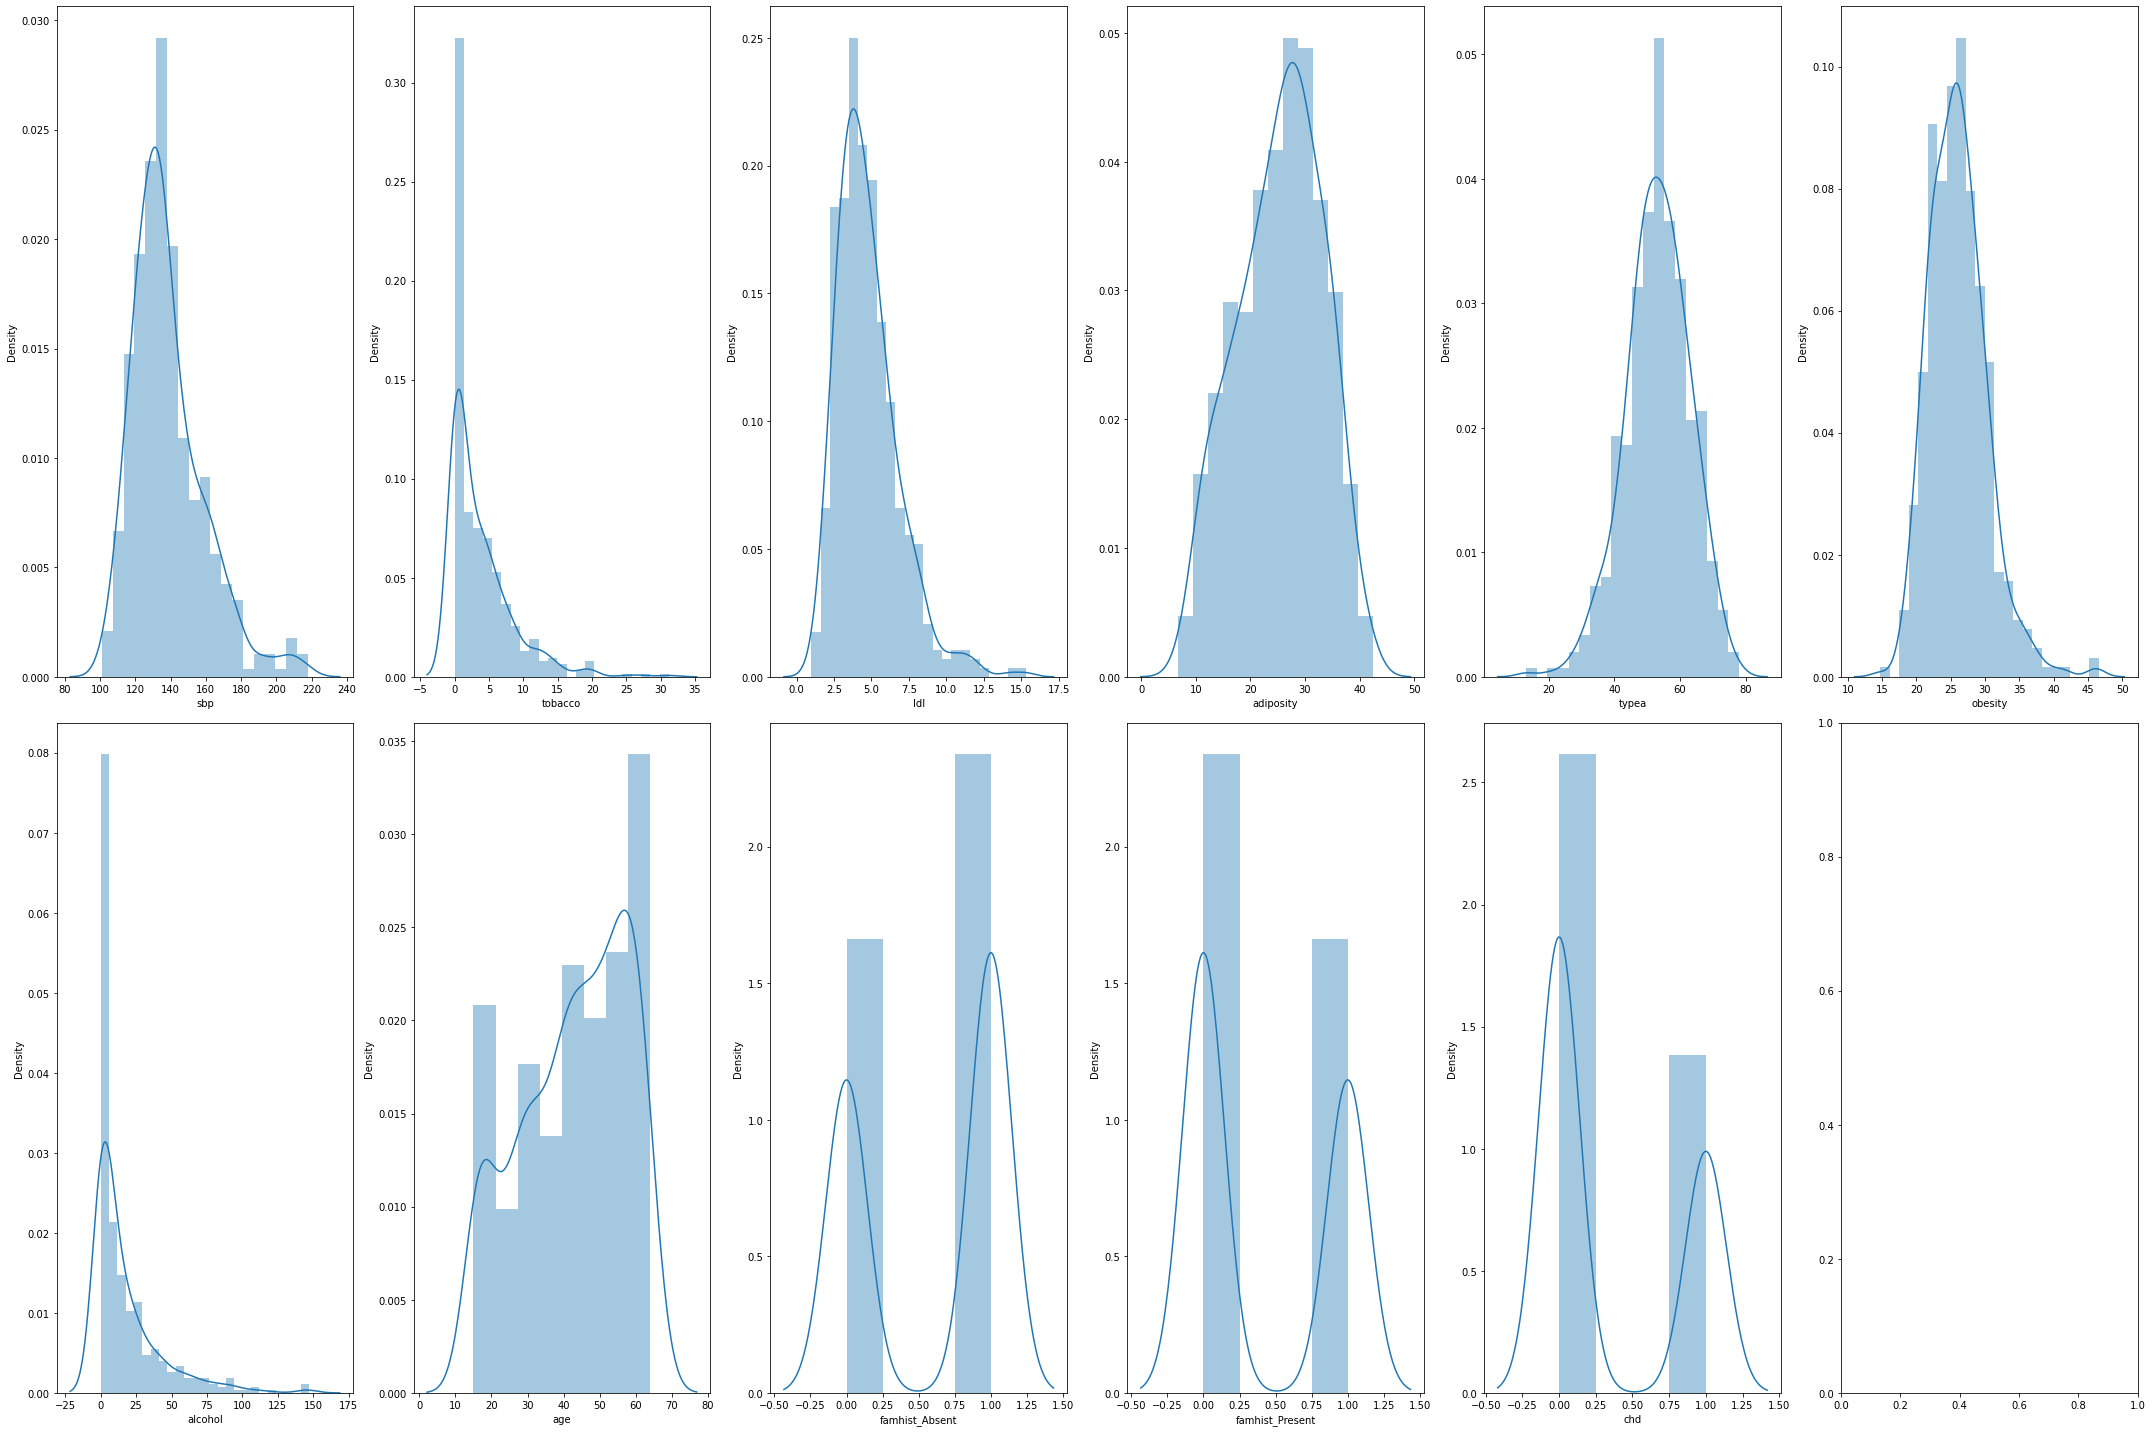

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(30, 20))
axs = axs.flatten()
index = 0
for k, v in data.items():
  sns.distplot(v, ax=axs[index])
  index += 1
plt.tight_layout()

اغلب ویژگی های دیتاست ما از توزیع نرمال پیروی می کند به خاطر همین برای مقیاس کردن دیتاست از استاندارد اسکالر استفاده میکنم

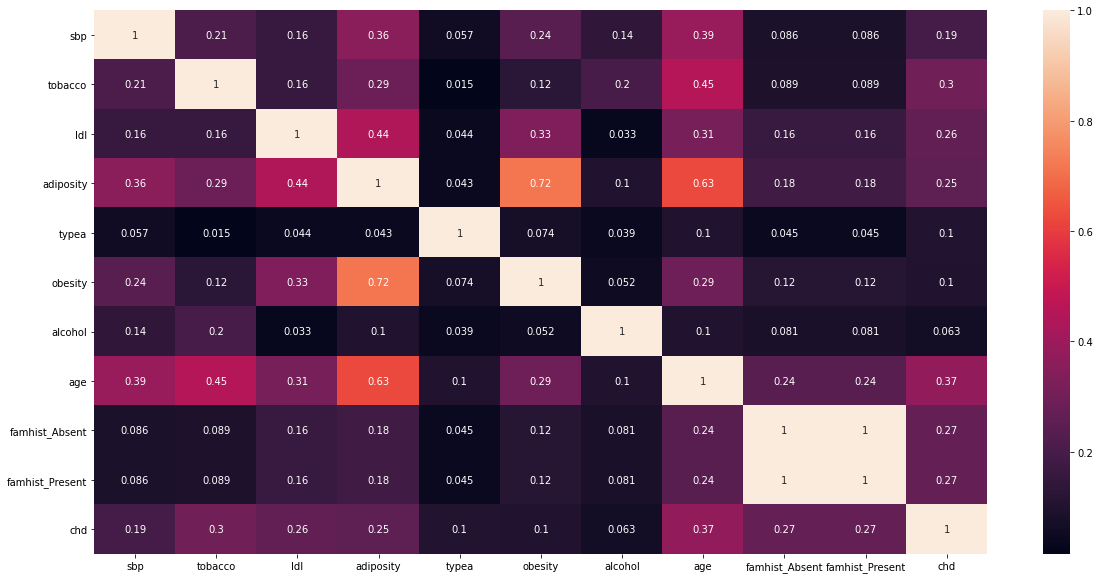

In [28]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(), annot=True)

In [29]:
class SAheartDataset(Dataset):
  def __init__(self, X, Y):
    
    # Feature scaling
    sc = StandardScaler()
    x_train = sc.fit_transform(X)
    y_train = Y.to_numpy()

    # convert to tensors
    self.X_train = torch.tensor(x_train, dtype=torch.float32)
    self.Y_train = torch.tensor(y_train)
  
  def __getitem__(self, idx):
    return self.X_train[idx], self.Y_train[idx]
  
  def __len__(self):
    return len(self.Y_train)


In [30]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

In [31]:
# Hyper-parameters
input_size = 10
hidden_size = 10000
num_classes = 2
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [32]:
from sklearn.model_selection import train_test_split


data = pd.read_csv("SAheart.data.csv")
data = pd.DataFrame(data=data)
data = pd.get_dummies(data)
data = data[['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity',
    'alcohol', 'age', 'famhist_Absent', 'famhist_Present', 'chd']]
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]


saheart_set = SAheartDataset(X, Y)
train_set, test_set = torch.utils.data.random_split(saheart_set, [362, 100], generator=torch.Generator().manual_seed(50))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, generator=torch.Generator().manual_seed(50))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False, generator=torch.Generator().manual_seed(50))

model = NeuralNet(input_size, hidden_size, num_classes)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
schedular = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [33]:
model.train()
# train model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (features, labels) in enumerate(train_loader):
    # features = features.reshape(-1, 10*10)

    # forward pass
    outputs = model(features)
    loss = criterion(outputs, labels)

    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  schedular.step()



In [34]:
y_pred = []
y_true = []

model.eval()
# Test the model
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    outputs = model(images)

    # max returns value, index
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted)

    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    labels = labels.data.numpy()
    y_true.extend(labels)

  acc = 100 * n_correct / n_samples
  print(f'Accuracy of the network on the test dataset: {acc} %')
  # for t, p in zip(labels.view(-1), predicted.view(-1)):
  #   confusion_matrix[t.long(), p.long()] += 1

Accuracy of the network on the test dataset: 63.0 %


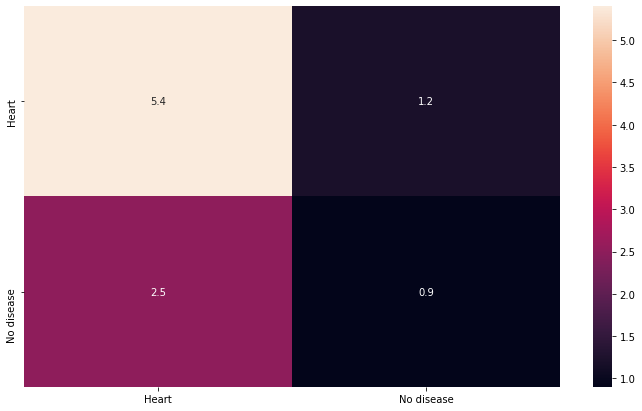

In [36]:
from sklearn import metrics

classes = ("Heart", "No disease")
cf_matrix = metrics.confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [37]:
print(confusion_matrix)

tensor([[8., 0.],
        [1., 1.]])


In [43]:
from sklearn.metrics import f1_score, recall_score
print(f"{f1_score(y_true, y_pred):.2f}")
print(f"{recall_score(y_true, y_pred):.2f}")

0.33
0.26


In [38]:
print(confusion_matrix.diag() / confusion_matrix.sum(1))

tensor([1.0000, 0.5000])
